In [34]:
import pandas as pd
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


In [3]:
def read_covid_time_series_data():
    return pd.read_csv('../../data/jhu/time_series_covid19_US.csv', parse_dates=['date'])

In [4]:
def create_year_month_column(df):
    df['yyyy-mm'] = df['date'].dt.strftime('%Y-%m')
    return df

In [5]:
def create_groupby_state_month(df):
    return df.groupby(['yyyy-mm', 'state']).last()['cases_conf_probable'].reset_index()

In [6]:
def remove_early_2020(df):
    return df.loc[~df['yyyy-mm'].isin(['2020-01', '2020-02']), :]

In [7]:
def clean_us_population(df):
    df.columns = ['state', 'population']
    df.iloc[:, 0] = df.iloc[:, 0].str[1:]
    df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1])
    return df

In [8]:
def read_us_population():
    df = pd.read_csv('../../data/us_population/nst-est2020.csv', header=None, thousands=',')
    df = clean_us_population(df)
    return df

In [9]:
def change_full_state_to_abbrev(df):
    for key, value in us_state_abbrev.items():
        df['state'].replace(key, value, inplace=True)
    return df

In [36]:
def normalize_state_by_population(pop_df, group_df):
    '''normalized the cases confirmed probable by that state's population'''
    merged_df = group_df.merge(pop_df, on='state')
    merged_df['positive_cases_normalized'] = merged_df['cases_conf_probable'] / merged_df['population']
    return merged_df

In [11]:
data = read_covid_time_series_data()

In [12]:
data = create_year_month_column(data)

In [13]:
group_by_state_month = create_groupby_state_month(data)

### choose March 2020 - March 2021

In [14]:
group_by_state_month.groupby('yyyy-mm').sum()

,cases_conf_probable
yyyy-mm,
2020-01,2.0
2020-02,18.0
2020-03,196814.0
2020-04,1073152.0
2020-05,1791343.0
2020-06,2623024.0
2020-07,4523187.0
2020-08,5980439.0
2020-09,7173102.0


In [15]:
group_by_state_month = remove_early_2020(group_by_state_month)

### Make new cases column

In [16]:
def create_new_monthly_cases(df):
    df = df.sort_values(by=['state', 'yyyy-mm']).reset_index(drop=True)
    df['new_cases_monthly'] = df['cases_conf_probable'].diff()
    return df


In [17]:
group_by_state_month = create_new_monthly_cases(group_by_state_month)

In [18]:
group_by_state_month

,yyyy-mm,state,cases_conf_probable,new_cases_monthly
0,2020-03,AK,128.0,NaN
1,2020-04,AK,355.0,227.0
2,2020-05,AK,463.0,108.0
3,2020-06,AK,944.0,481.0
4,2020-07,AK,2993.0,2049.0
...,...,...,...,...
723,2020-11,WY,33305.0,20007.0
724,2020-12,WY,44409.0,11104.0
725,2021-01,WY,51912.0,7503.0
726,2021-02,WY,54394.0,2482.0


In [19]:
def get_row_of_negative(df):
    '''checking which rows in the groupings are negative'''
    month_where_negative = list()
    for state in df.state.unique():
        month_where_negative.append(df.loc[(df['state'] == state) \
                                   & (df['new_cases_monthly'] < 0), 'yyyy-mm'].values)
    return month_where_negative

#get_row_of_negative(group_by_state_month)

# groupings seem to be the first row in year and monthly data

In [37]:
def make_first_row_cumulative_case(df):
    for state in df.state.unique():
        value_to_change = df.loc[df['state'] == state, 'cases_conf_probable'].head(1)
        df.loc[df['state'] == state, 'new_cases_monthly'].iloc[0,] = value_to_change
    return df

In [21]:
group_by_state_month = make_first_row_cumulative_case(group_by_state_month)

<class 'pandas.core.series.Series'>


In [22]:
group_by_state_month[group_by_state_month['state'] == 'TX']

,yyyy-mm,state,cases_conf_probable,new_cases_monthly
611,2020-03,TX,3266.0,-790871.0
612,2020-04,TX,28087.0,24821.0
613,2020-05,TX,64287.0,36200.0
614,2020-06,TX,159986.0,95699.0
615,2020-07,TX,420946.0,260960.0
616,2020-08,TX,612969.0,192023.0
617,2020-09,TX,748967.0,135998.0
618,2020-10,TX,900596.0,151629.0
619,2020-11,TX,1278432.0,377836.0
620,2020-12,TX,1756172.0,477740.0


### Normalize by the population of each state

In [23]:
population = read_us_population()

In [24]:
abbrev_population = change_full_state_to_abbrev(population)

In [26]:
normalized_df = normalize_state_by_population(abbrev_population, group_by_state_month)

### visualization to show the positive_cases_normalized by month and state

<AxesSubplot:xlabel='yyyy-mm', ylabel='positive_cases_normalized'>

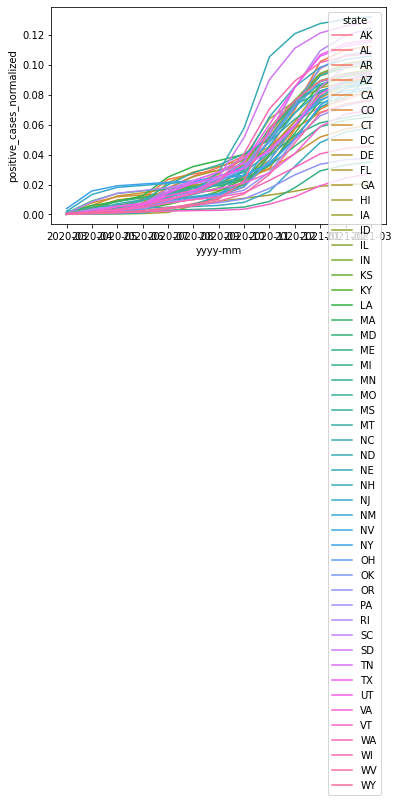

In [35]:
sns.lineplot(x=normalized_df['yyyy-mm'], y=normalized_df['positive_cases_normalized'], hue=normalized_df['state'])

To get the months that would are the most different, let's try comparing states that have the highest vs lowerst positive cases confirmed

In [64]:
def get_highest_lowest_cases_state(month, df):
    '''given a month and the df, finds the states that had the lowest and highest number of positive cases normalized'''
    least_cases = df.loc[df['yyyy-mm']==month, ['state', 'positive_cases_normalized']]\
                    .sort_values('positive_cases_normalized').state.values[0:5]
    highest_cases = df.loc[df['yyyy-mm']==month, ['state', 'positive_cases_normalized']]\
                    .sort_values('positive_cases_normalized', ascending=False).state.values[0:5]
    return least_cases, highest_cases                                                                                                    

In [65]:
def create_highest_lowest_cases_df(df):
    month_dict = dict()
    for month in df['yyyy-mm']:
        month_dict[month] = get_highest_lowest_cases_state(month, df)
    return month_dict

In [66]:
def cases_series_to_states_only(df):
    for col in df.columns:
        df[col] = df[col]

In [67]:
highest_lowest_df = pd.DataFrame.from_dict(create_highest_lowest_cases_df(normalized_df), orient='index', columns=['Lowest Cases', 'Highest Cases'])

In [69]:
highest_lowest_df

,Lowest Cases,Highest Cases
2020-03,"[NE, WV, KY, TX, SD]","[NY, NJ, MI, LA, MA]"
2020-04,"[MT, HI, AK, OR, WV]","[NY, NJ, MA, RI, CT]"
2020-05,"[HI, MT, AK, OR, WV]","[NY, NJ, RI, MA, DC]"
2020-06,"[HI, MT, AK, WV, VT]","[NY, NJ, RI, MA, DC]"
2020-07,"[HI, VT, ME, MT, WV]","[LA, AZ, NY, FL, NJ]"
2020-08,"[VT, ME, NH, WV, HI]","[LA, FL, MS, AZ, AL]"
2020-09,"[VT, ME, NH, OR, HI]","[LA, MS, FL, AL, GA]"
2020-10,"[VT, ME, NH, OR, HI]","[ND, SD, WI, MS, LA]"
2020-11,"[VT, ME, HI, NH, OR]","[ND, SD, WI, NE, IA]"
2020-12,"[VT, HI, ME, OR, WA]","[ND, SD, WI, NE, TN]"


In [31]:
normalized_df

,yyyy-mm,state,cases_conf_probable,new_cases_monthly,population,positive_cases_normalized
0,2020-03,AK,128.0,NaN,731158,0.000175
1,2020-04,AK,355.0,227.0,731158,0.000486
2,2020-05,AK,463.0,108.0,731158,0.000633
3,2020-06,AK,944.0,481.0,731158,0.001291
4,2020-07,AK,2993.0,2049.0,731158,0.004094
...,...,...,...,...,...,...
658,2020-11,WY,33305.0,20007.0,582328,0.057193
659,2020-12,WY,44409.0,11104.0,582328,0.076261
660,2021-01,WY,51912.0,7503.0,582328,0.089146
661,2021-02,WY,54394.0,2482.0,582328,0.093408
